# Motivation

In this notebook the results from the 2nd version of the Network pipeline developed in my PhD thesis. The following changes were made:
* the non-tumour dataset was used
* hierarchical Stochastic Block Model (hSBM) was used instead of Leiden 
* Sigmoid weight modifiers for reward
* MEV - integrates the expression of both the non-tumour dataset and the tumour

In [3]:
%load_ext autoreload
import pandas as pd
import numpy as np
import os
import sys
import igraph as ig
import pickle

import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.io as pio

import multiprocess as mp

SCRIPT_DIR = os.path.dirname(os.path.abspath("pcgna_processing.py"))
sys.path.append(os.path.dirname(SCRIPT_DIR))
sys.path.append('/Users/vlad/Documents/Code/York/iNet_v2/src/')

from NetworkAnalysis.ExperimentSet import ExperimentSet
from NetworkAnalysis.NetworkOutput import NetworkOutput
from NetworkAnalysis import GraphHelper as gh
from NetworkAnalysis.utilities import sankey_consensus_plot as sky
from NetworkAnalysis.utilities.helpers import save_fig, survival_plot, survival_comp
from NetworkAnalysis.GraphToolExp import GraphToolExperiment as GtExp
import NetworkAnalysis.utilities.clustering as cs
from NetworkAnalysis.NetworkComp import NetworkComp



# Gsea libraries
import gseapy as gp
import matplotlib.pyplot as plt

import graph_tool.all as gt

# %matplotlib inline

pio.templates.default = "ggplot2"


pool = mp.Pool(mp.cpu_count())

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
results_path = "../../results/exp/"
data_base = "../../data/"
base_path = "../../results/"

figures_path = "../network_ii/validation/"

base_sbm_path = "../../../iNet_v2/"
sbm_exps_path = "results/sbm/"

exp_folder_tumour = "network_I/tum/"


vu_output = pd.read_csv(f"{data_base}/metadata/VU_clustering_v3.tsv", sep="\t", index_col="Sample")

tcga_mutations_df = pd.read_csv(f"{data_base}/tumour/mutations_tcga.csv")
tcga_mutations_df = tcga_mutations_df[tcga_mutations_df["count"] != 0].set_index("gene")

all_tum_tpms = pd.read_csv(f"{data_base}/tumour/tum_TPMs_selected_genes_gc42_all_v4.tsv", sep="\t", index_col="genes")


healthy_metadata = pd.read_csv(f"{data_base}/metadata/healthy_bladder_metadata.tsv", sep="\t", index_col="Sample", dtype_backend="pyarrow")

# tf list
tf_path = f"{data_base}/metadata/TF_names_v_1.01.txt"
if os.path.exists(tf_path):
    tf_list = np.genfromtxt(fname=tf_path, delimiter="\t", skip_header=1, dtype="str")

# Load experiments

In [5]:
tum = ExperimentSet("tum", base_path, exp_folder_tumour, tcga_mutations_df, sel_sets = ["5K"], rel_path="../")

%autoreload 2
exps = {}
for key, exp in tum.exps.items():
    tf = int(exp.type.split("_")[-1].split("TF")[0])
    modifier = exp.type.split("_")[0]
    if tf != 6 or modifier == 'beta':
        continue

    exp.export_to_gephi(save=False)
    graph_stats = exp.compute_graph_stats()
    exp.nodes_df = pd.concat([graph_stats, exp.nodes_df], axis=1)

    exps[key] = exp


tum.exps = exps
print(tum.get_exp_labels())

##### Experiment labels:  dict_keys(['standard_5K_50TF', 'beta_5K_50TF', 'norm2_5K_50TF', 'norm3_5K_50TF', 'standard_5K_6TF', 'standard_5K_5TF', 'standard_5K_4TF', 'standard_5K_3TF', 'norm3_5K_5TF', 'norm3_5K_4TF', 'norm3_5K_6TF', 'beta_5K_3TF', 'beta_5K_4TF', 'beta_5K_6TF', 'norm3_5K_3TF', 'standard_5K_7TF', 'standard_5K_8TF', 'beta_5K_7TF', 'standard_5K_9TF', 'standard_5K_10TF', 'norm3_5K_7TF', 'norm3_5K_8TF', 'beta_5K_8TF', 'norm3_5K_9TF', 'beta_5K_9TF', 'beta_5K_10TF', 'norm3_5K_10TF', 'beta_5K_5TF'])
['standard_5K_6TF', 'norm3_5K_6TF']


In [6]:
hsbm_v3 = ExperimentSet("v3", base_path=base_sbm_path, exp_path=sbm_exps_path, mut_df=tcga_mutations_df, sel_sets=None, exp_type="iNet")

exps = {}
for idx, exp in enumerate(hsbm_v3.get_exps()):
    # if exp.sbm_method != "hsbm":  # or idx != 2:
    #     continue

    print(f"Loading Graph-Tool for {exp.type}")
    exp = GtExp.from_pgcna_inet(exp, rel_path="")

    # partitions from hSBM
    if exp.sbm_method == "sbm":
        exp.add_vp(mut_df=tcga_mutations_df)
        com_df = exp.get_gt_df()

    else:
        exp.hsbm_add_vp(mut_df=tcga_mutations_df)
        com_df, _ = exp.hsbm_get_gt_df()
        com_df["max_b"] = com_df["P_lvl_0"]

    # export to gephi
    exp.export_to_gephi(save=False, com_df=com_df)

    # Need it for comparison
    exps[exp.type] = exp

hsbm_v3.exps = exps

##### Experiment labels:  dict_keys(['standard_5K_6TF_sbm', 'standard_5K_6TF_hsbm', 'sigmoid_5K_6TF_hsbm'])
Loading Graph-Tool for standard_5K_6TF_sbm
Loading Graph-Tool for standard_5K_6TF_hsbm
Loading Graph-Tool for sigmoid_5K_6TF_hsbm


In [7]:
std_exp: GtExp = hsbm_v3.exps["standard_5K_6TF_hsbm"]
rwd_exp: GtExp = hsbm_v3.exps["sigmoid_5K_6TF_hsbm"]

std_com_df, _ = std_exp.hsbm_get_gt_df()
rwd_com_df, _ = rwd_exp.hsbm_get_gt_df()
std_nodes_df: pd.DataFrame = gh.add_stats_to(nodes_df=std_exp.nodes_df, tpm_df=std_exp.tpm_df)
rwd_nodes_df: pd.DataFrame = gh.add_stats_to(nodes_df=rwd_exp.nodes_df, tpm_df=rwd_exp.tpm_df)

# Analysis

## Network metrics



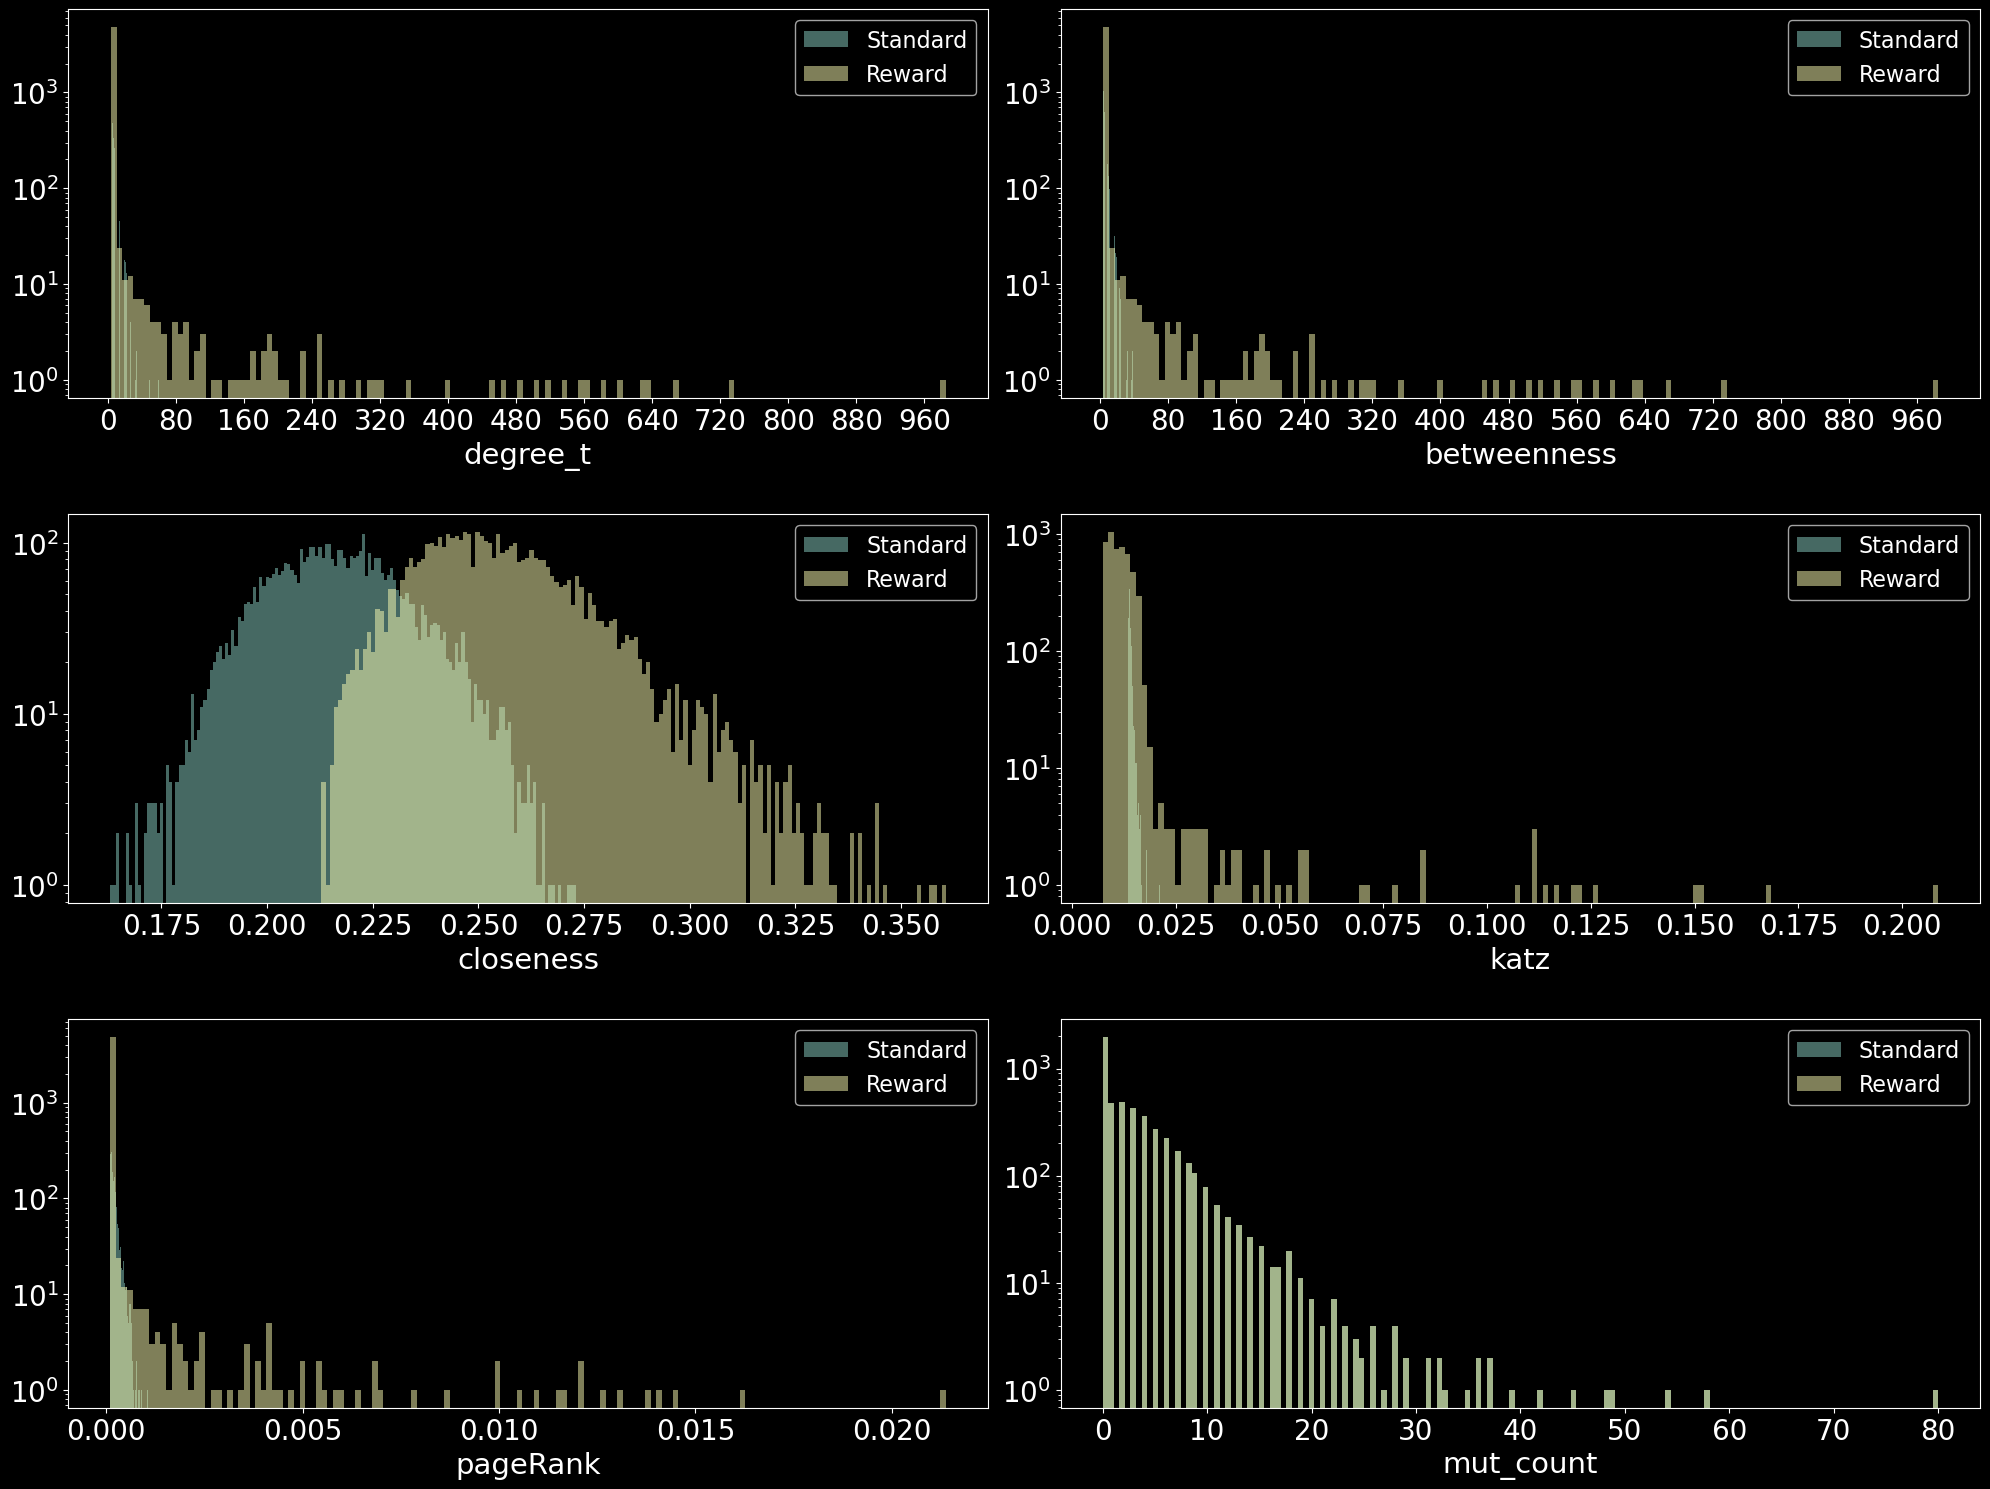

In [8]:
comp_std_net: NetworkComp = NetworkComp(hsbm_v3, 5, "standard_5K_6TF_hsbm", "sigmoid_5K_6TF_hsbm", mod_type="sbm")

fig, graph_stats_std, graph_stats_rwd = comp_std_net.plot_network_stats(nodes_df_1=std_nodes_df, nodes_df_2=rwd_nodes_df, label_1="Standard", label_2="Reward")

comb_df = pd.concat([rwd_nodes_df, std_nodes_df.rename(columns={"IVI": "IVI_std"})], axis=1).sort_values(by=["IVI", "IVI_std"], ascending=False)[
    ["IVI", "IVI_std"]
]

In [9]:
std_nt: GtExp = hsbm_v3.exps["standard_5K_6TF_hsbm"]
rwrd_nt: GtExp = hsbm_v3.exps["sigmoid_5K_6TF_hsbm"]
std_sts = std_nt.compute_graph_stats()
rwrd_sts = rwrd_nt.compute_graph_stats()

std_sts["IVI"] = std_nt.nodes_df["IVI"]
rwrd_sts["IVI"] = rwrd_nt.nodes_df["IVI"]

std_sts["Type"] = "Non-Tum Std"
rwrd_sts["Type"] = "Non-Tum Rwd"

combined_df = pd.concat([std_sts, rwrd_sts], axis=0).reset_index(names="gene")

combined_df["TF"] = combined_df["gene"].apply(lambda gene: std_nt.nodes_df.loc[gene]["TF"])
combined_df["TF"].fillna(0, inplace=True)
combined_df["TF"] = combined_df["TF"].astype(str)
combined_df["degree"] = combined_df["degree_w"]
combined_df["betwenees"] = combined_df["betweenness"]

# tum nodes df
tum_nodes_std = tum.exps["standard_5K_6TF"].nodes_df
tum_nodes_rwd = tum.exps["norm3_5K_6TF"].nodes_df

tum_nodes_std["Type"] = "Tum Std"
tum_nodes_rwd["Type"] = "Tum Rwd"

cols = ["degree", "pageRank", "closeness", "betwenees", "IVI", "Type"]
combined_df = pd.concat([tum_nodes_std[cols], tum_nodes_rwd[cols], combined_df], axis=0)

In [10]:
fig = gh.plot_net_metrics(combined_df, log_y=True, label="Tumour vs Non-tumnour", color="Type", filename="network_comparison", figs_path=figures_path)

## Compare MEV

There are three different implementations of MEV:

1. First - following Matthew's Care principle and not taking in account the difference in GE between the one used to build the network and the one for stratification 
2. Second - Takes in account the GE difference between the dataset used for net and the one for stratification
3. Third - Also uses the mutations

In [44]:
sel_gt: GtExp = hsbm_v3.exps["standard_5K_6TF_hsbm"]

# Pre-process the tcga_mutations_df to contains all the genes in the tpm_df
mut_df = tcga_mutations_df.copy(deep=True)
missing_genes = list(set(sel_gt.tpm_df.index) - set(mut_df.index))

mut_df = mut_df.reindex(mut_df.index.union(missing_genes), fill_value=0)
mut_df = mut_df.loc[sel_gt.tpm_df.index].drop(columns="count")
mut_df = mut_df[all_tum_tpms.columns]

In [45]:
########## Runing the MEVs  ##########

#### Normal MEV
sel_gt.gt_modCon_MEV(all_tpms=all_tum_tpms, is_imev=False, com_df=com_df)
mev1 = sel_gt.mevsMut.copy(deep=True)
cs_mev1, fig_mev1, metrics_mev1 = gh.run_clusters(sel_gt, label="mev1", show_figs=True, norm=False)

#### iMEV + mutation
sel_gt.gt_modCon_MEV(all_tpms=all_tum_tpms, is_imev=True, com_df=com_df)
mev2 = sel_gt.mevsMut.copy(deep=True)
cs_mev2, fig_mev2, metrics_mev2 = gh.run_clusters(sel_gt, label="mev2", show_figs=True, norm=False)

#### iMEV + mutation
sel_gt.gt_modCon_MEV(all_tpms=all_tum_tpms, is_imev=True, com_df=com_df, mut_df=mut_df, offset=1)
mev3 = sel_gt.mevsMut.copy(deep=True)
cs_mev3, fig_mev3, metrics_mev3 = gh.run_clusters(sel_gt, label="mev3", show_figs=True, norm=False)

Variation per principal component [0.57213399 0.27335227] and the sum 84.55%
Variation per principal component [0.58358354 0.26629199] and the sum 84.99%
### Running with mut_ofset 1
Variation per principal component [0.58315677 0.26562773] and the sum 84.88%


In [46]:
# Combine eveyrthing
comb_df = pd.concat(
    [
        cs_mev1.drop(columns=["PC_1", "PC_2"]),
        cs_mev2.drop(columns=["PC_1", "PC_2"]),
        cs_mev3.drop(columns=["PC_1", "PC_2"]),
        vu_output.drop(columns=["PC_1", "PC_2"]),
    ],
    axis=1,
).dropna()

num = 6
model = f"RawKMeans_CS_{num}_mev"

comb_df["MEV_1"] = comb_df[f"{model}1"]
comb_df["MEV_2"] = comb_df[f"{model}2"]
comb_df["MEV_3"] = comb_df[f"{model}3"]

reorder_cols = [
    "TCGA_2017_AM_remap",
    "KMeans_labels_6",
    "MEV_1",
    "MEV_2",
    # "MEV_3",
    "2019_consensus_classifier",
]
_, sky_fig = sky.main(df=comb_df, reorder_cols=reorder_cols, title="v3. Comp between iMevs-Mut vs iMev", retMeta=True)

In [47]:
sky_fig.update_layout(
    title="",
    font=dict(size=18),
)

### Top Metrics comparison

In [20]:
top_mev1 = gh.rank_cs_metrics(metrics_mev1, label="mev1")
top_mev2 = gh.rank_cs_metrics(metrics_mev2, label="mev2")
top_mev3 = gh.rank_cs_metrics(metrics_mev3, label="mev3")

pd.concat([top_mev1, top_mev2, top_mev3], axis=1)

,mev1,mev2,mev3
Sil_cos_1,Avg_4,Avg_4,Avg_4
Sil_cos_2,Avg_8,Avg_5,Avg_5
Sil_cos_3,Avg_5,Avg_6,Avg_6
Cal_hab_1,KM_4,KM_4,KM_4
Cal_hab_2,Spec_4,Spec_4,GaussianMixture_4
Cal_hab_3,GaussianMixture_4,GaussianMixture_4,Spec_4
Dav_bou_1,Spec_5,Avg_6,Spec_4
Dav_bou_2,KM_7,Spec_4,Spec_7
Dav_bou_3,Spec_7,Wrd_4,KM_4


## Compare SBM vs hSBM

In the PhD thesis I make the case that the hSBM finds more communities than SBM so I need to show that difference.

In [2]:
if 0:
    sel_gt = hsbm_v3.exps["standard_5K_6TF_sbm"]
    fig = sel_gt.plot_partition_prob()
    fig.show()

In [1]:
if 0:
    sel_gt = hsbm_v3.exps["standard_5K_6TF_hsbm"]
    fig = sel_gt.hsbm_plot_posterior()
    fig.show()

## Gene distribution in healthy and tumour

This is useful to show the expression distribution for a gene in the tumour dataset, where it is the mean and what it means the std deviation

In [38]:
import seaborn as sns


def gene_distribution(tpm_df: pd.DataFrame, gene="STAT2"):

    dmy_ds = tpm_df.loc[gene]

    # Pick a sample from dmy_ds
    sample = np.random.choice(dmy_ds)

    # Increase the number of bins
    num_bins = 20

    # Plot the histogram with increased bins and random x-axis values
    sns.histplot(dmy_ds, bins=num_bins, kde=True)
    plt.axvline(dmy_ds.mean(), color="r", linestyle="--", label="Mean")
    plt.axvline(dmy_ds.mean() + dmy_ds.std(), color="g", linestyle="--", label="Mean + Std Dev")
    plt.axvline(dmy_ds.mean() - dmy_ds.std(), color="g", linestyle="--", label="Mean - Std Dev")
    plt.axvline(sample, color="b", linestyle="--", label="Sample")
    plt.legend()
    plt.show()

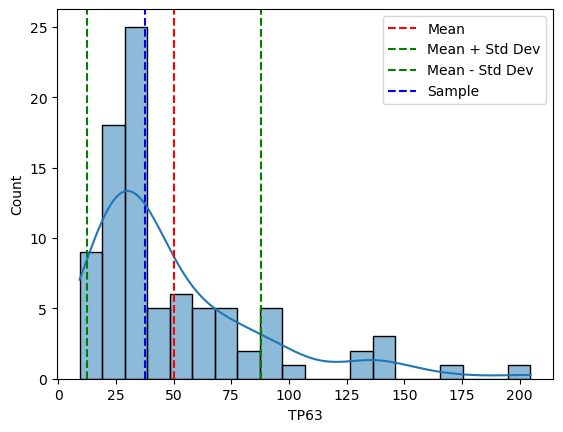

In [39]:
if 1:
    gene_distribution(sel_gt.tpm_df, gene="TP63")

## Level membership

In [9]:
if 0:
    fig = sel_gt.hsbm_plot_posterior()
    fig.show()